This notebook creates and then trains naive templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, copy
from scipy.interpolate import interp1d

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Create the naive templates

In [5]:
def log_norm(x,mode,sigma):
    mu = np.log(mode) + sigma**2
    f1 = lambda x: 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    return f1(x)/f1(5000)

N = 8
n = 3
modes  = np.concatenate((np.linspace(5500,4600,n,endpoint=False),np.linspace(4600,1000,N-n)))
sigmas = np.concatenate((np.linspace(0.35,0.56,n,endpoint=False),np.linspace(0.56, 0.9,N-n)))

# save the templates as Seds
x = np.arange(10,15000,100,dtype=float)
naive_templates = dict()
for i in range(N):
    template = Sed()
    template.wavelen = x
    template.flambda = log_norm(x,modes[i],sigmas[i])
    naive_templates["N8_"+str(i+1)] = template

Save the naive templates

In [6]:
"""for template in naive_templates:
    file = open('templates/'+template+'_untrained.sed','w')
    x = copy.copy(naive_templates[template].wavelen)
    y = copy.copy(naive_templates[template].flambda)
    # upsample to every 10 angstroms
    xnew = np.arange(x[0],x[-1],10)
    ynew = np.interp(xnew,x,y)
    for i in range(len(xnew)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(xnew[i],ynew[i]))
    file.close()""";

Create training sets and plot them

In [6]:
%%time
training_sets = create_training_sets(naive_templates,galaxies,bandpass_dict)

CPU times: user 1min 44s, sys: 35.7 ms, total: 1min 44s
Wall time: 1min 44s


Number of fluxes in each training set:
[66342, 57125, 53317, 69559, 66587, 27356, 33574, 37868]


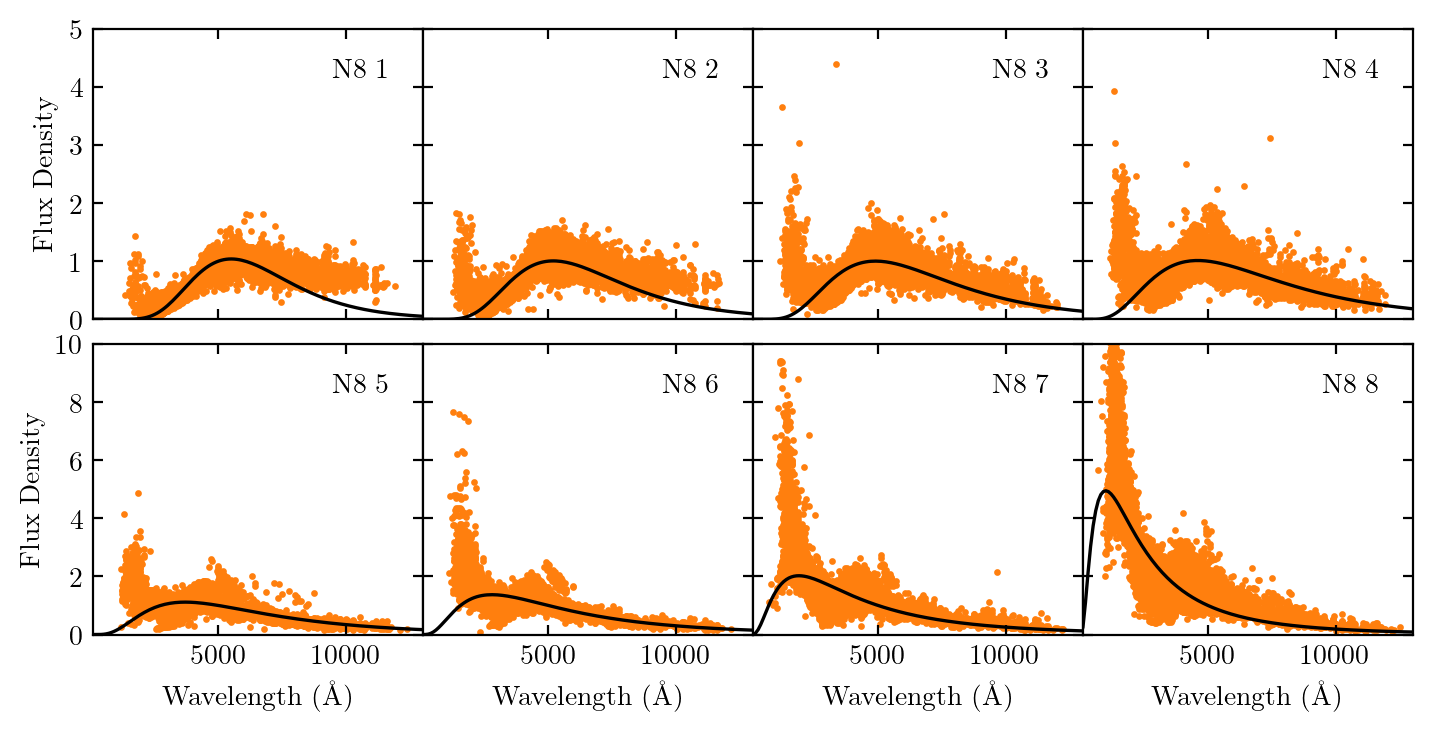

In [7]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols))

print("Number of fluxes in each training set:")
print([len(i) for i in training_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in training_sets["N8_"+str(i+1)]]
    fluxes  = [row[1] for row in training_sets["N8_"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = naive_templates["N8_"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, c="k")
    
    ax.text(0.9,0.9,"N8 "+str(i+1),transform=ax.transAxes,ha="right",va="top")
    
    ax.set_xlim(100,13000)

axes[0,0].set_ylim(0,5)
axes[1,0].set_ylim(0,10)
axes[1,0].set_yscale('symlog',linthreshy=20)

axes[1,0].set_yticks([0,2,4,6,8,10])
axes[1,0].set_yticklabels([0,2,4,6,8,10])

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/N8_untrained.png')

Now train the templates

In [8]:
%%time
trained_templates, final_sets = train_templates(naive_templates, galaxies, bandpass_dict, N_iter=3, w=0.5)

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5
Generating final sets
Done!
CPU times: user 22min 3s, sys: 2.36 s, total: 22min 5s
Wall time: 20min 43s


Save the results!

In [18]:
"""for template in trained_templates:
    file = open('templates/'+template+'.sed','w')
    x = copy.copy(trained_templates[template].wavelen)
    y = copy.copy(trained_templates[template].flambda)
    # upsample to every 10 angstroms
    xnew = np.arange(x[0],x[-1],10)
    ynew = np.interp(xnew,x,y)
    for i in range(len(xnew)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(xnew[i],ynew[i]))
    file.close()""";

Plot the trained templates

In [10]:
"""# Load the trained templates from files if you didn't run the training algorithm
trained_templates = dict()
for template in naive_templates:
    x,y = np.loadtxt('templates/'+template+'.sed',unpack=True)
    trained_templates[template] = Sed(x,y)
    
final_sets = create_training_sets(trained_templates, galaxies, bandpass_dict)""";

Number of fluxes in each training set:
[41867, 43942, 50062, 58790, 68682, 67223, 54690, 26472]


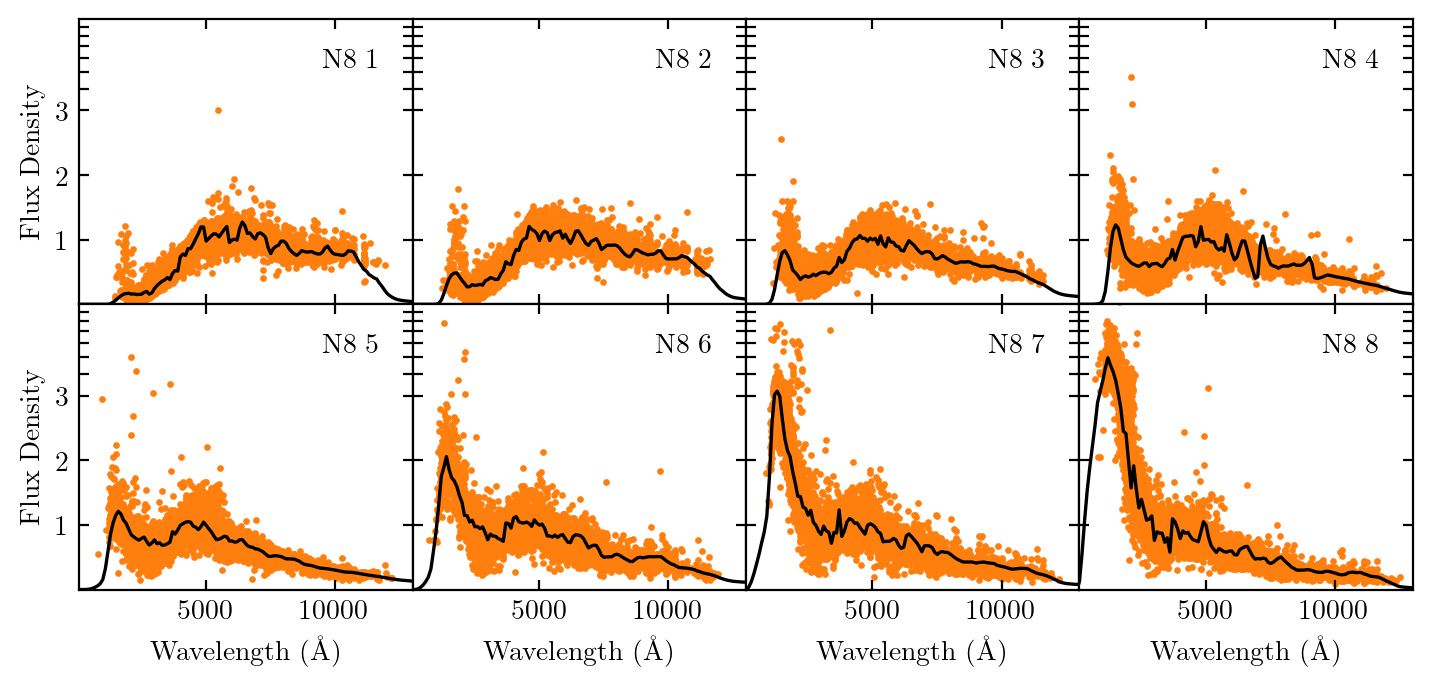

In [16]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.95))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in final_sets["N8_"+str(i+1)]]
    fluxes  = [row[1] for row in final_sets["N8_"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = trained_templates["N8_"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, c="k")
    
    ax.text(0.9,0.9,"N8 "+str(i+1),transform=ax.transAxes,ha="right",va="top")

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
    ax.set_xlim(100,13000)
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    ax.set_yscale('symlog',linthreshy=3)
    ax.set_ylim(0,10)
    ax.set_yticks([1,2,3,4,5,6,7,8,9])
    ax.set_yticklabels([1,2,3,'','','','','',''])
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/N8_trained.png')

Number of fluxes in each training set:
[41867, 43942, 50062, 58790, 68682, 67223, 54690, 26472]


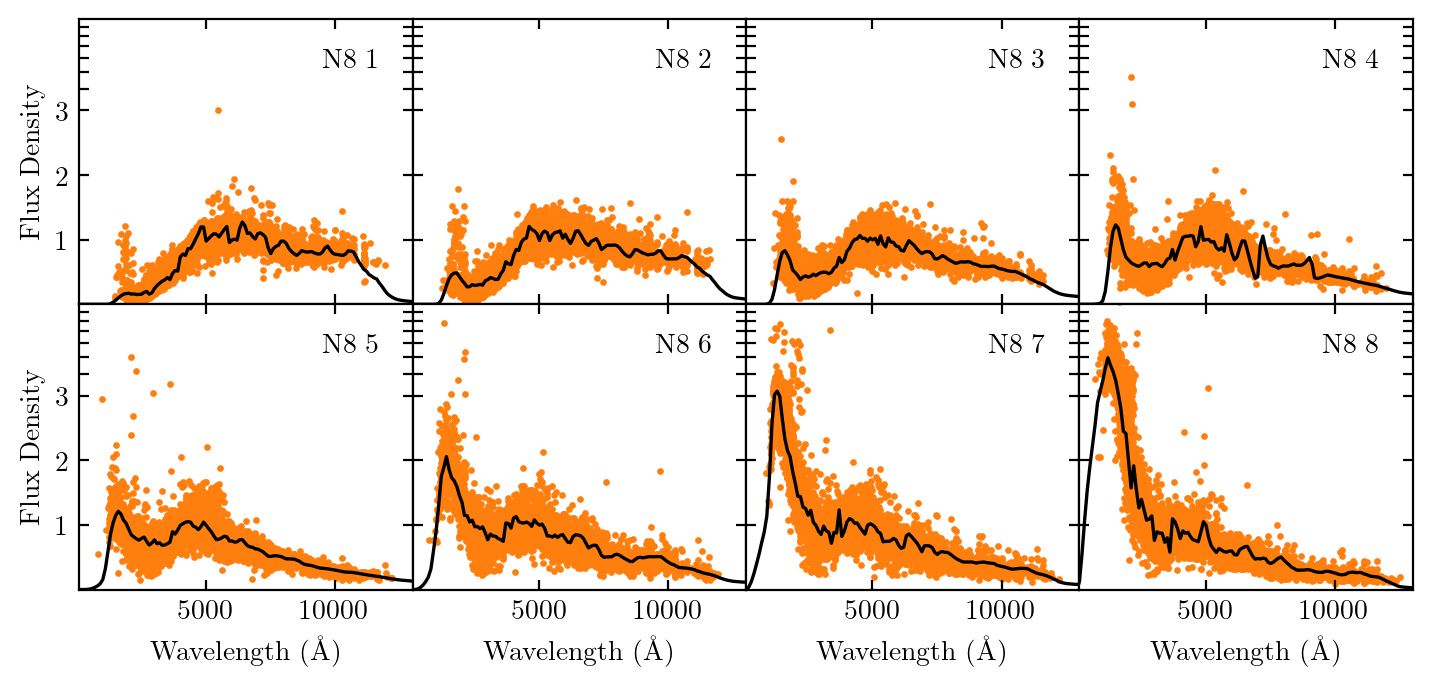

In [15]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.95))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in final_sets["N8_"+str(i+1)]]
    fluxes  = [row[1] for row in final_sets["N8_"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = trained_templates["N8_"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, c="k")
    
    ax.text(0.9,0.9,"N8 "+str(i+1),transform=ax.transAxes,ha="right",va="top")

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
    ax.set_xlim(100,13000)
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    ax.set_yscale('symlog',linthreshy=3)
    ax.set_ylim(0,10)
    ax.set_yticks([1,2,3,4,5,6,7,8,9])
    ax.set_yticklabels([1,2,3,'','','','','',''])
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/N8_trained.png')